### Exploratory Data Overview

This section loads the cleaned GoodRx dataset and performs initial exploratory analysis:

1. **Dataset Information & Summary Statistics**
   - View column names, data types, and non-null counts.
   - Generate descriptive statistics for all columns.

2. **Missing Data Check**
   - Count missing values per column to identify data quality issues.

3. **Categorical Insights**
   - List unique drugs and cities present in the dataset.
   - Count the number of unique pharmacies.

4. **Special Offer Distribution**
   - Display frequency counts of different special offer types.

5. **Online vs. In-Store Pharmacies**
   - Count how many listings are for online pharmacies vs. in-store.

6. **Grouped Price Statistics**
   - Calculate count, mean, standard deviation, min, and max prices grouped by:
     - `city`
     - `drug`
     - `dosage`


In [12]:
import pandas as pd

df = pd.read_csv('goodrx_cleaned_data.csv')

# Overview and basic statistics
print(df.info())
print(df.describe(include='all'))

# Missing data summary
print('\nMissing values per column:')
print(df.isnull().sum())

# Unique values in key categorical columns
print('\nUnique drugs:', df['drug'].unique())
print('Unique cities:', df['city'].unique())
print('Unique pharmacies:', df['pharmacy'].nunique())

# Distribution of "special offers"
print('\nSpecial offer counts:')
print(df['special_offer'].value_counts())

# Online vs In-Store pharmacy counts
print('\nOnline pharmacy value counts:')
print(df['online_pharmacy'].value_counts())

# Sample group statistics
grouped = df.groupby(['city', 'drug', 'dosage'])['price'].agg(['count', 'mean', 'std', 'min', 'max'])
print('\nGrouped price stats by city, drug, dosage:')
print(grouped.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   drug                   291 non-null    object 
 1   location               291 non-null    int64  
 2   dosage                 291 non-null    object 
 3   quantity               291 non-null    object 
 4   pharmacy               291 non-null    object 
 5   price                  291 non-null    float64
 6   special_offer          291 non-null    object 
 7   standard_coupon_price  192 non-null    float64
 8   special_coupon_price   192 non-null    float64
 9   online_pharmacy        291 non-null    bool   
 10  city                   291 non-null    object 
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 23.1+ KB
None
             drug      location dosage    quantity      pharmacy       price  \
count         291    291.000000    291         291           2

### Function: `generate_enhanced_goodrx_eda`

Generates a set of interactive Plotly visualizations to explore cleaned GoodRx drug pricing data.

**Purpose:**
- Provide a comprehensive visual overview of drug prices across different cities, pharmacies, and quantities.
- Highlight key patterns such as average pricing, special offer distribution, online vs in-store differences, and outliers.

**Visualizations Produced:**
1. **Price Distribution by Drug & City** – Box plot to compare spread and medians.
2. **Average Prices** – Grouped bar chart showing mean prices by city and drug.
3. **Special Offer Distribution** – Donut chart summarizing special offer prevalence.
4. **Online vs In-Store Pricing** – Violin plot comparing price distributions.
5. **Quantity-Based Price Variation** – Strip plot showing how quantity affects price.
6. **Cheapest Pharmacies** – Faceted bar chart of lowest prices for top drug-dosage combinations.
7. **Coupon Price Comparison** – Scatter plot comparing standard vs special coupon prices.
8. **Price Outliers** – Box plot identifying unusual price points.

**Parameters:**
- `df` *(DataFrame)*: Cleaned GoodRx dataset.

**Returns:**
- Displays interactive charts directly in the notebook.


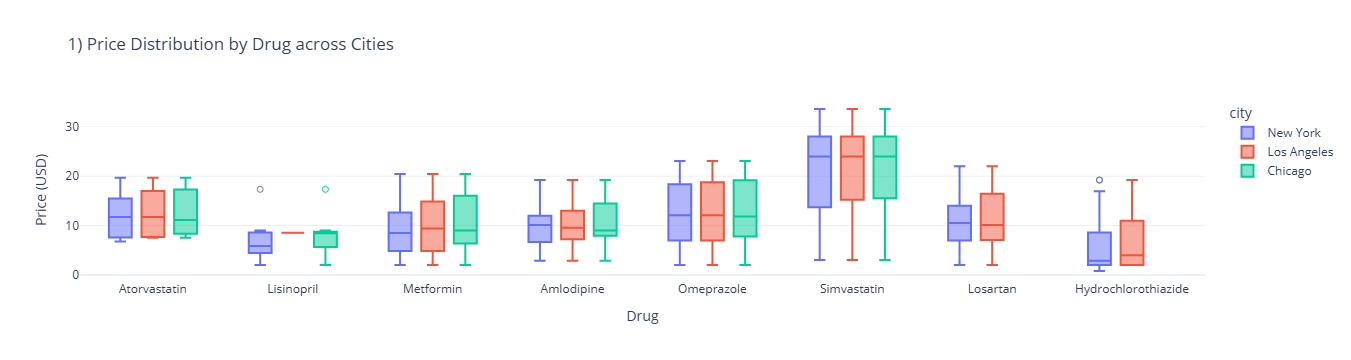

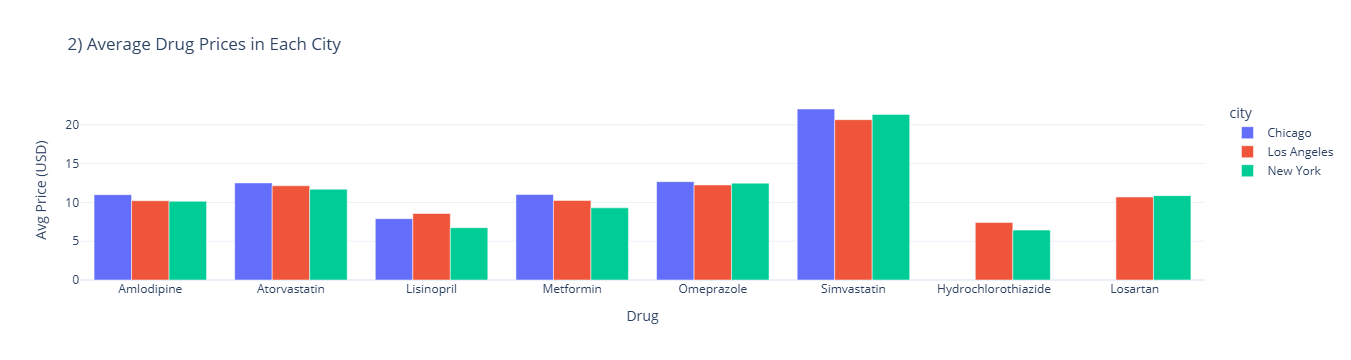

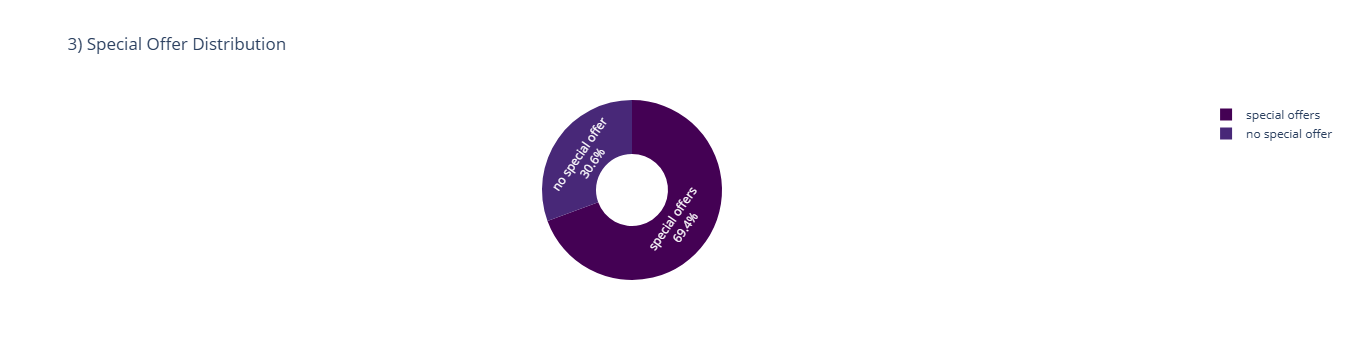

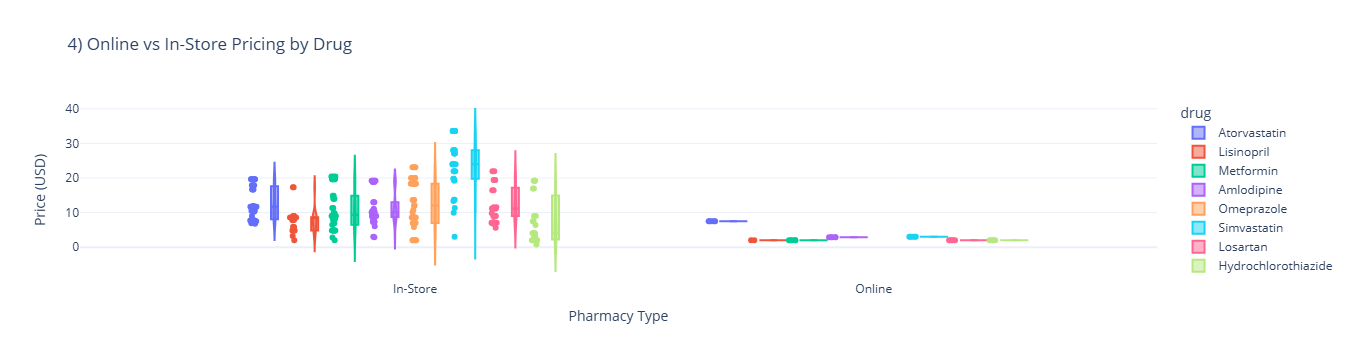

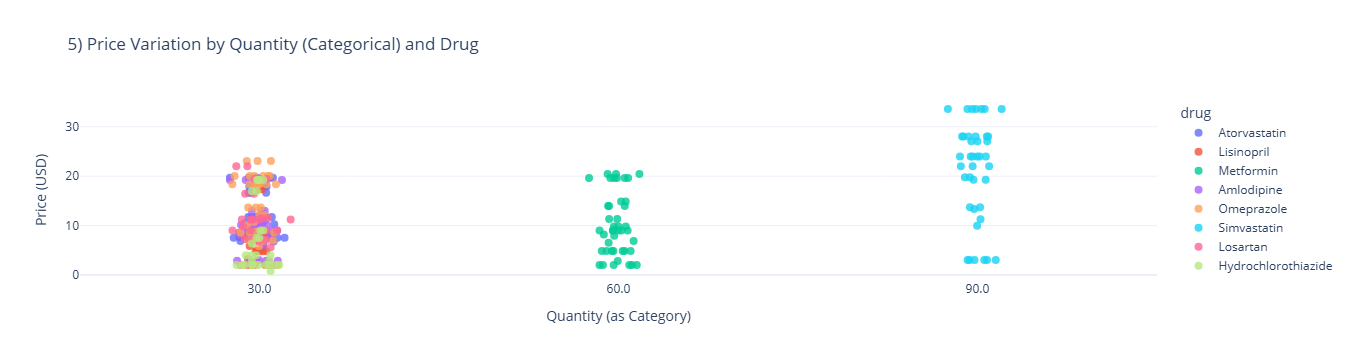

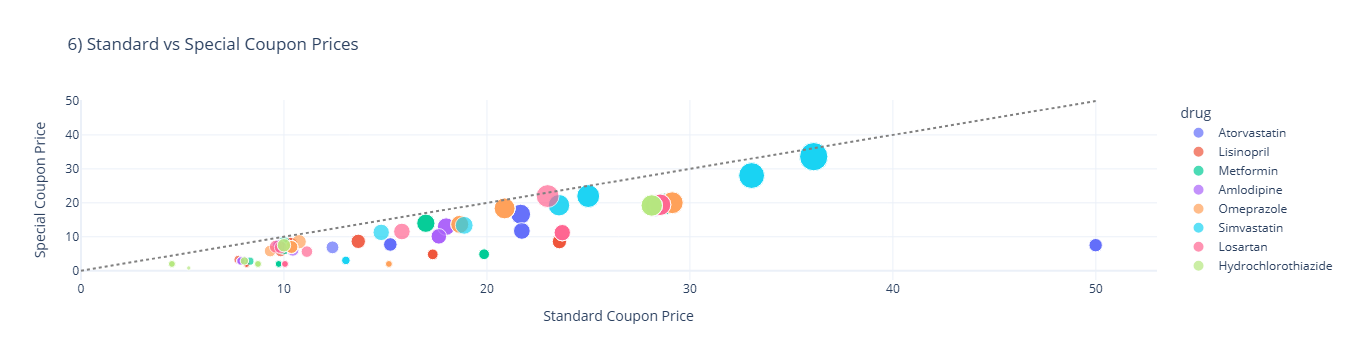

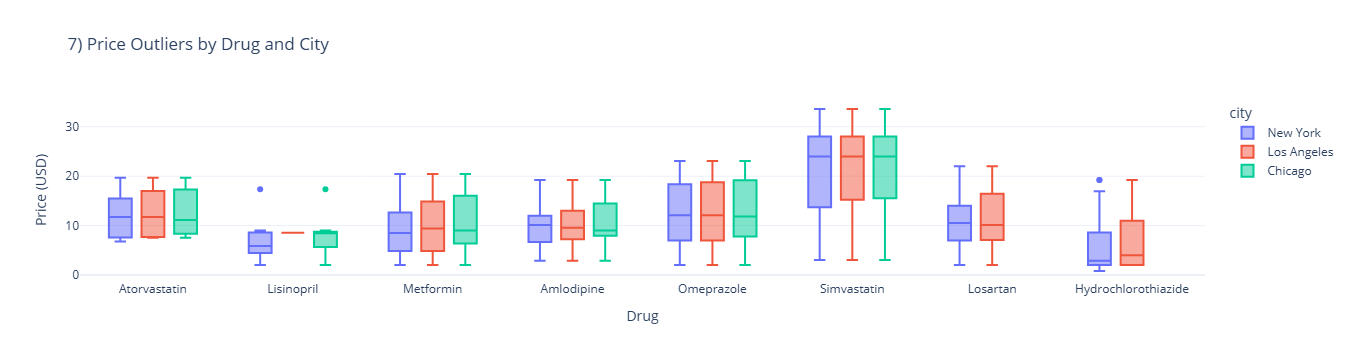

In [15]:
import plotly.express as px
import pandas as pd

def generate_enhanced_goodrx_eda(df):
    """
    Generates improved interactive Plotly visualizations for GoodRx drug pricing data.
    (Adjusted: removed former #6 'Cheapest pharmacies' chart; numbering updated.)
    """

    # 0) Prep & helper columns
    # Clean quantity column (convert "30 tablets" -> 30)
    df['quantity_clean'] = df['quantity'].astype(str).str.extract(r'(\d+)').astype(float)

    # Grouped/prepared data
    avg_prices = df.groupby(['city', 'drug'])['price'].mean().reset_index()
    offer_counts = df['special_offer'].value_counts(dropna=False).reset_index()
    offer_counts.columns = ['special_offer', 'count']
    coupon_df = df.dropna(subset=['standard_coupon_price', 'special_coupon_price'])

    # 1) Box Plot: Price distribution across cities and drugs
    fig1 = px.box(
        df, x='drug', y='price', color='city', points='suspectedoutliers',
        title='1) Price Distribution by Drug across Cities',
        labels={'price': 'Price (USD)', 'drug': 'Drug'}
    )
    fig1.update_layout(boxmode='group', template='plotly_white')
    fig1.show()

    # 2) Bar Chart: Average prices by city and drug
    fig2 = px.bar(
        avg_prices, x='drug', y='price', color='city', barmode='group',
        title='2) Average Drug Prices in Each City',
        labels={'price': 'Avg Price (USD)', 'drug': 'Drug'}
    )
    fig2.update_layout(template='plotly_white')
    fig2.show()

    # 3) Donut Chart: Special offer status
    fig3 = px.pie(
        offer_counts, names='special_offer', values='count',
        hole=0.4, title='3) Special Offer Distribution',
        color_discrete_sequence=px.colors.sequential.Viridis
    )
    fig3.update_layout(template='plotly_white')
    fig3.update_traces(textposition='inside', textinfo='percent+label')
    fig3.show()

    # 4) Violin Plot: Online vs In-store pricing by drug
    # Map boolean values to descriptive labels
    df['pharmacy_type'] = df['online_pharmacy'].map({True: 'Online', False: 'In-Store'})
    fig4 = px.violin(
        df,
        x='pharmacy_type',
        y='price',
        color='drug',
        box=True,
        points='all',
        title='4) Online vs In-Store Pricing by Drug',
        labels={'pharmacy_type': 'Pharmacy Type', 'price': 'Price (USD)'}
    )
    fig4.update_layout(template='plotly_white')
    fig4.show()

    # 5) Strip Plot: Price by Quantity Category and Drug
    df['quantity_cat'] = df['quantity_clean'].astype(str)  # Convert to string category
    fig5 = px.strip(
        df,
        x='quantity_cat',
        y='price',
        color='drug',
        hover_data=['city', 'pharmacy', 'online_pharmacy'],
        title='5) Price Variation by Quantity (Categorical) and Drug',
        labels={'quantity_cat': 'Quantity (as Category)', 'price': 'Price (USD)'},
        stripmode='overlay'
    )
    fig5.update_traces(jitter=0.4, marker=dict(size=8, opacity=0.8))
    fig5.update_layout(template='plotly_white')
    fig5.show()

    # 6) Coupon Comparison (previously #7)
    if not coupon_df.empty:
        fig6 = px.scatter(
            coupon_df,
            x='standard_coupon_price', y='special_coupon_price',
            color='drug', size='price',
            hover_data=['city', 'pharmacy'],
            title='6) Standard vs Special Coupon Prices',
            labels={
                'standard_coupon_price': 'Standard Coupon Price',
                'special_coupon_price': 'Special Coupon Price'
            }
        )
        max_price = max(
            coupon_df['standard_coupon_price'].max(),
            coupon_df['special_coupon_price'].max()
        )
        fig6.add_shape(
            type="line", x0=0, y0=0, x1=max_price, y1=max_price,
            line=dict(dash="dot", color="gray")
        )
        fig6.update_layout(template='plotly_white')
        fig6.show()

    # 7) Outlier Box Plot (previously #8)
    fig7 = px.box(
        df, x='drug', y='price', color='city', points='outliers',
        title='7) Price Outliers by Drug and City',
        labels={'price': 'Price (USD)', 'drug': 'Drug'}
    )
    fig7.update_layout(template='plotly_white')
    fig7.show()


# 🧪 Load your data and call the function
generate_enhanced_goodrx_eda(df)
